In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import warnings
import os
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# Load the dataset
a1 = pd.read_excel("/kaggle/input/leading-indian-bank-and-cibil-real-world-dataset/Internal_Bank_Dataset.xlsx")
a2 = pd.read_excel("/kaggle/input/leading-indian-bank-and-cibil-real-world-dataset/External_Cibil_Dataset.xlsx")

In [3]:
df1 = a1.copy()
df2 = a2.copy()

In [4]:
# Remove nulls
df1 = df1.loc[df1['Age_Oldest_TL'] != -99999]

In [5]:
columns_to_be_removed = []

for i in df2.columns:
    if df2.loc[df2[i] == -99999].shape[0] > 10000:
        columns_to_be_removed .append(i)


In [6]:
df2 = df2.drop(columns_to_be_removed, axis =1)

In [7]:
for i in df2.columns:
    df2 = df2.loc[ df2[i] != -99999 ]

In [8]:
# Checking common column names
for i in list(df1.columns):
    if i in list(df2.columns):
        print (i)

PROSPECTID


In [9]:
# Merge the two dataframes, inner join so that no nulls are present
df = pd. merge ( df1, df2, how ='inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'] )

In [10]:
df.head()

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,1,5,4,1,0,0,0.000,0.0,0.200,0.800,...,0.0,0.0,0.000,0.0,1,0,PL,PL,696,P2
1,2,1,0,1,0,0,0.000,0.0,1.000,0.000,...,0.0,0.0,0.000,0.0,0,0,ConsumerLoan,ConsumerLoan,685,P2
2,3,8,0,8,1,0,0.125,0.0,1.000,0.000,...,0.0,0.0,0.000,0.0,1,0,ConsumerLoan,others,693,P2
3,5,3,2,1,0,0,0.000,0.0,0.333,0.667,...,0.0,0.0,0.000,0.0,0,0,AL,AL,753,P1
4,6,6,5,1,0,0,0.000,0.0,0.167,0.833,...,1.0,0.0,0.429,0.0,1,0,ConsumerLoan,PL,668,P3


In [11]:
# check how many columns are categorical
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)

MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


In [12]:
# Chi-square test
for i in ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    print(i, '---', pval)

MARITALSTATUS --- 3.578180861038862e-233
EDUCATION --- 2.6942265249737532e-30
GENDER --- 1.907936100186563e-05
last_prod_enq2 --- 0.0
first_prod_enq2 --- 7.84997610555419e-287


In [13]:
# Since all the categorical features have pval <=0.05, we will accept al

In [14]:
# VIF for numerical columns
numeric_columns = []
for i in df.columns:
    if df[i].dtype != 'object' and i not in ['PROSPECTID','Approved_Flag']:
        numeric_columns.append(i)

In [15]:
# VIF sequentially check

vif_data = df[numeric_columns]
total_columns = vif_data.shape[1]
columns_to_be_kept = []
column_index = 0


In [16]:
for i in range (0,total_columns):

    vif_value = variance_inflation_factor(vif_data, column_index)
    print (column_index,'---',vif_value)


    if vif_value <= 6:
        columns_to_be_kept.append( numeric_columns[i] )
        column_index = column_index+1

    else:
        vif_data = vif_data.drop([ numeric_columns[i] ] , axis=1)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf


/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf
0 --- 11.320180023967996
0 --- 8.363698035000336
0 --- 6.520647877790928
0 --- 5.149501618212625
1 --- 2.611111040579735


/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


2 --- inf
2 --- 1788.7926256209232
2 --- 8.601028256477228
2 --- 3.8328007921530785
3 --- 6.0996533816467355
3 --- 5.581352009642762
4 --- 1.985584353098778


/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


5 --- inf
5 --- 4.809538302819343
6 --- 23.270628983464636
6 --- 30.595522588100053
6 --- 4.3843464059655854
7 --- 3.0646584155234238
8 --- 2.898639771299252
9 --- 4.377876915347322
10 --- 2.207853583695844
11 --- 4.916914200506864
12 --- 5.214702030064725
13 --- 3.3861625024231476
14 --- 7.840583309478997
14 --- 5.255034641721434


/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


15 --- inf
15 --- 7.380634506427232
15 --- 1.4210050015175733
16 --- 8.083255010190323
16 --- 1.6241227524040114
17 --- 7.257811920140003
17 --- 15.59624383268298
17 --- 1.825857047132431
18 --- 1.5080839450032661
19 --- 2.172088834824578
20 --- 2.6233975535272305
21 --- 2.2959970812106167
22 --- 7.360578319196446
22 --- 2.1602387773102554
23 --- 2.8686288267891467
24 --- 6.458218003637272
24 --- 2.8474118865638265
25 --- 4.7531981562840855
26 --- 16.227354755948223
26 --- 6.424377256363877
26 --- 8.887080381808687
26 --- 2.3804746142952653
27 --- 8.609513476514548
27 --- 13.06755093547673
27 --- 3.5000400566546555
28 --- 1.908795587481377
29 --- 17.006562234161628
29 --- 10.730485153719197
29 --- 2.3538497522950275
30 --- 22.104855915136433
30 --- 2.7971639638512906
31 --- 3.424171203217696
32 --- 10.175021454450935
32 --- 6.408710354561301
32 --- 1.001151196262562
33 --- 3.069197305397274
34 --- 2.8091261600643724
35 --- 20.249538381980678
35 --- 15.864576541593745
35 --- 1.833164974

In [17]:
# check Anova for columns_to_be_kept

from scipy.stats import f_oneway

columns_to_be_kept_numerical = []

for i in columns_to_be_kept:
    a = list(df[i])
    b = list(df['Approved_Flag'])

    group_P1 = [value for value, group in zip(a, b) if group == 'P1']
    group_P2 = [value for value, group in zip(a, b) if group == 'P2']
    group_P3 = [value for value, group in zip(a, b) if group == 'P3']
    group_P4 = [value for value, group in zip(a, b) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)

In [18]:
# feature selection is done for cat and num features

In [19]:
# listing all the final features
features = columns_to_be_kept_numerical + ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
df = df[features + ['Approved_Flag']]

In [20]:
# Label encoding for the categorical features
['MARITALSTATUS', 'EDUCATION', 'GENDER' , 'last_prod_enq2' ,'first_prod_enq2']

['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']

In [21]:
df['MARITALSTATUS'].unique()
df['EDUCATION'].unique()
df['GENDER'].unique()
df['last_prod_enq2'].unique()
df['first_prod_enq2'].unique()


array(['PL', 'ConsumerLoan', 'others', 'AL', 'HL', 'CC'], dtype=object)

In [22]:
# Ordinal feature -- EDUCATION
# SSC            : 1
# 12TH           : 2
# GRADUATE       : 3
# UNDER GRADUATE : 3
# POST-GRADUATE  : 4
# OTHERS         : 1
# PROFESSIONAL   : 3

In [23]:
# Others has to be verified by the business end user
df.loc[df['EDUCATION'] == 'SSC',['EDUCATION']]              = 1
df.loc[df['EDUCATION'] == '12TH',['EDUCATION']]             = 2
df.loc[df['EDUCATION'] == 'GRADUATE',['EDUCATION']]         = 3
df.loc[df['EDUCATION'] == 'UNDER GRADUATE',['EDUCATION']]   = 3
df.loc[df['EDUCATION'] == 'POST-GRADUATE',['EDUCATION']]    = 4
df.loc[df['EDUCATION'] == 'OTHERS',['EDUCATION']]           = 1
df.loc[df['EDUCATION'] == 'PROFESSIONAL',['EDUCATION']]     = 3

In [24]:
df['EDUCATION'].value_counts()
df['EDUCATION'] = df['EDUCATION'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42064 entries, 0 to 42063
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pct_tl_open_L6M            42064 non-null  float64
 1   pct_tl_closed_L6M          42064 non-null  float64
 2   Tot_TL_closed_L12M         42064 non-null  int64  
 3   pct_tl_closed_L12M         42064 non-null  float64
 4   Tot_Missed_Pmnt            42064 non-null  int64  
 5   CC_TL                      42064 non-null  int64  
 6   Home_TL                    42064 non-null  int64  
 7   PL_TL                      42064 non-null  int64  
 8   Secured_TL                 42064 non-null  int64  
 9   Unsecured_TL               42064 non-null  int64  
 10  Other_TL                   42064 non-null  int64  
 11  Age_Oldest_TL              42064 non-null  int64  
 12  Age_Newest_TL              42064 non-null  int64  
 13  time_since_recent_payment  42064 non-null  int

In [25]:
df_encoded = pd.get_dummies(df, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])

In [26]:
df_encoded.info()
k = df_encoded.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42064 entries, 0 to 42063
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pct_tl_open_L6M               42064 non-null  float64
 1   pct_tl_closed_L6M             42064 non-null  float64
 2   Tot_TL_closed_L12M            42064 non-null  int64  
 3   pct_tl_closed_L12M            42064 non-null  float64
 4   Tot_Missed_Pmnt               42064 non-null  int64  
 5   CC_TL                         42064 non-null  int64  
 6   Home_TL                       42064 non-null  int64  
 7   PL_TL                         42064 non-null  int64  
 8   Secured_TL                    42064 non-null  int64  
 9   Unsecured_TL                  42064 non-null  int64  
 10  Other_TL                      42064 non-null  int64  
 11  Age_Oldest_TL                 42064 non-null  int64  
 12  Age_Newest_TL                 42064 non-null  int64  
 13  t

In [27]:
# Machine Learing model fitting
# Data processing

In [28]:
y = df_encoded['Approved_Flag']
x = df_encoded. drop ( ['Approved_Flag'], axis = 1 )

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [30]:
# Apply standard scaler

from sklearn.preprocessing import StandardScaler

columns_to_be_scaled = ['Age_Oldest_TL','Age_Newest_TL','time_since_recent_payment',
'max_recent_level_of_deliq','recent_level_of_deliq',
'time_since_recent_enq','NETMONTHLYINCOME','Time_With_Curr_Empr']

for i in columns_to_be_scaled:
    column_data = df_encoded[i].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaled_column = scaler.fit_transform(column_data)
    df_encoded[i] = scaled_column

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.regularizers import l2

# Sample data preparation (replace with your actual data loading)
# x_train, x_test, y_train, y_test

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.transform(y_test)

# Standardize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert numeric labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_numeric)
y_test_one_hot = to_categorical(y_test_numeric)

# Build improved ANN model
model = Sequential()
model.add(Dense(54, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(27, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(12, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(len(np.unique(y_train_numeric)), activation='softmax'))  # Number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(x_train, y_train_one_hot, epochs=100, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
y_pred_proba = model.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert numeric predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Print accuracy and classification report
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'ANN - Accuracy: {accuracy:.2f}')
print(f'Classification Report for ANN:\n{classification_report(y_test, y_pred_labels)}')


2024-08-14 13:50:06.627284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 13:50:06.627399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 13:50:06.749381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
 85/842 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2220 - loss: 3.0260

I0000 00:00:1723643424.444488      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


842/842 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4646 - loss: 2.1861 - val_accuracy: 0.7290 - val_loss: 1.0980 - learning_rate: 0.0010
Epoch 2/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6969 - loss: 1.0686 - val_accuracy: 0.7543 - val_loss: 0.7578 - learning_rate: 0.0010
Epoch 3/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7175 - loss: 0.8053 - val_accuracy: 0.7584 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 4/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7176 - loss: 0.7407 - val_accuracy: 0.7639 - val_loss: 0.6352 - learning_rate: 0.0010
Epoch 5/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7230 - loss: 0.7189 - val_accuracy: 0.7616 - val_loss: 0.6285 - learning_rate: 0.0010
Epoch 6/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7297 - loss: 0.7086 - val_accuracy: 0.7610 - val_loss: 0.6256 - learning_rate: 0.0010
Epoch 7/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7230 - loss: 0.7147 - val_

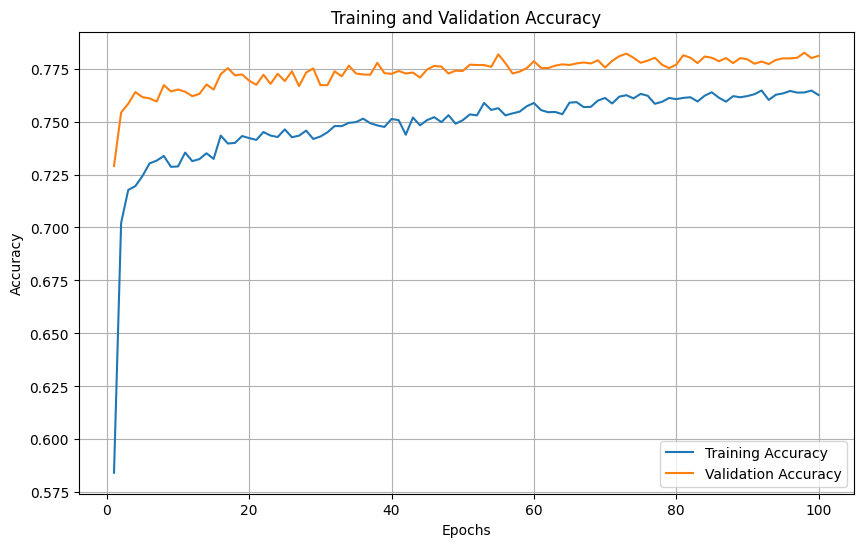

In [32]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable containing the training history
history_dict = history.history

# Extract accuracy and validation accuracy
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
